# Bayesian regression using PyMC and STAN

Report any errors to Joris De Ridder.

## Imports

In [ ]:
import sys
print("Python version: ", sys.version)

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
print("NumPy version: ", np.__version__)
print("SciPy version: ", sp.__version__)
print("Pandas version: ", pd.__version__)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
print("Statsmodels version: ", sm.__version__)

In [ ]:
import pymc as pm
import pytensor
import pytensor.tensor as pt 
print("PyMC version: ", pm.__version__)
print("PyTensor version: ", pytensor.__version__)

In [ ]:
import stan
import nest_asyncio
nest_asyncio.apply()
print("PyStan version: ", stan.__version__)

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
print("Matplotlib version: ", matplotlib.__version__)

In [ ]:
import seaborn as sns
import plotly
print("Seaborn version: ", seaborn.__version__)
print("Plotly version: ", plotly.__version__)

In [ ]:
import arviz as az
print("Arviz version: ", az.__version__)

In [ ]:
import corner
print("Corner version: ", corner.__version__)

In [ ]:
import lmfit
import sympy
import sklearn
print("lmfit version: ", lmfit.__version__)
print("sympy version: ", sympy.__version__)
print("sklearn version: ", sklearn.__version__)

## Matplotlib font sizes

In [ ]:
plt.rc('font',   size=15)          # controls default text sizes
plt.rc('axes',   titlesize=15)     # fontsize of the axes title
plt.rc('axes',   labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=15)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=15)     # fontsize of the tick labels
plt.rc('legend', fontsize=15)      # legend fontsize
plt.rc('figure', titlesize=15)     # fontsize of the figure title

## Links to documentation on the web

* [PyMC documentation](https://docs.pymc.io)
* [PyMC examples](https://www.pymc.io/projects/examples/en/latest/gallery.html)
* [Stan documentation](https://mc-stan.org/docs/2_26/stan-users-guide/index.html).
* [Stan example models](https://github.com/stan-dev/example-models)
* [A brief guide to Stan's warnings](https://mc-stan.org/misc/warnings.html)

## Contents

* [Basic linear regression [PyMC]](#Basic-linear-regression-with-PyMC)
* [Basic linear regression [Stan]](#Basic-linear-regression-with-Stan)
* [Robust regression using a Student's T-distribution [PyMC]](#Robust-regression-using-a-StudentT-likelihood-with-PyMC)
* [Robust regression using the Hogg et al. approach [PyMC]](#Robust-regression-using-the-Hogg-approach-with-PyMC)
* [Robust regression using the Hogg et al. approach [Stan]](#Robust-regression-using-the-Hogg-approach-with-Stan)
* [Piecewise linear regression [PyMC]](#Piecewise-linear-regression-with-PyMC)
* [Piecewise linear regression [Stan]](#Piecewise-linear-regression-with-Stan)
* [Uncertainties in y and x [Stan]](#Uncertainties-in-y-and-x-with-Stan)
* [Uncertainties in y and x [PyMC]](#Uncertainties-in-y-and-x-with-PyMC)
* [Fitting a distribution to a dataset [PyMC]](#Modeling-a-distribution-for-a-dataset-with-PyMC)
* [Binomial logistic regression [Stan]](#Fitting-a-binomial-logistic-model-with-Stan)
* [Binomial logistic regression [PyMC]](#Fitting-a-logistic-model-with-PyMC)
* [Multinomial logistic regression [Stan]](#A-multinomial-logistic-model-with-Stan)
* [Multinomial logistic regression [PyMC]](#A-multinomial-logistic-model-with-PyMC)
* [Modeling a fraction with Beta [Stan]](#Modeling-a-fraction-with-the-Beta-distribution-with-Stan)
* [Modeling counts with Poisson [PyMC]](#Modeling-counts-with-Poisson-with-PyMC)
* [Modeling counts with Poisson [Stan]](#Modeling-counts-with-Poisson-with-Stan)
* [Modeling counts with Negative Binomial [PyMC]](#Modeling-counts-with-Negative-Binomial-with-PyMC)
* [Modeling counts with Negative Binomial [Stan]](#Modeling-counts-with-Negative-Binomial-with-Stan)
* [Zero-truncated Poisson model [Stan]](#A-zero-truncated-Poisson-model-with-Stan)
* [Zero-truncated Poisson model [PyMC]](#A-zero-truncated-Poisson-model-with-PyMC)


## Basic linear regression with PyMC

#### A synthetic dataset:

In [ ]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2
sigma = 0.3

x = np.linspace(0, 1, N)
y = theta0 + theta1 * x + rng.normal(0.0, sigma, N)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The Bayesian model

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$


See the [PyMC3 documentation](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfCauchy) on the definition of the HalfCauchy distribution.

In [ ]:
with pm.Model() as myModel:
    
    xobs = pm.MutableData("xobs", x)
    yobs = pm.MutableData("yobs", y)
    
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

#### Summary of the trace

In [ ]:
az.summary(trace, var_names=['intercept', 'slope', 'sigma'], hdi_prob=0.95, round_to=5)

The mean posterior values of the fit parameters can be obtained as follows:

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

#### Verify the behavior of the chains

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Auto-correlation functions:

In [ ]:
fig = az.plot_autocorr(trace, var_names=("intercept", "slope"), max_lag=50, combined=True)

#### One and two-dimensional projections of the posterior samples

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(8,8))                                       # 3 because we're showing 3 params
fig = corner.corner(trace, fig=fig, var_names=['intercept', 'slope', 'sigma'],
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

In [ ]:
myPlot = az.plot_posterior(trace, var_names=['intercept', 'slope'], point_estimate='mean', hdi_prob=0.95, textsize=15, round_to=4)

Arviz allows to make a 2D contour plot of posterior samples: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

#### Plotting the posterior model and the data

I first stack all the samples of all chains in one large stack.

In [ ]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

In [ ]:
MAP = pm.find_MAP(model=myModel)
MAPintercept = MAP['intercept']
MAPslope = MAP['slope']
print("MAP value intercept: ", MAPintercept)
print("MAP value slope: ", MAPslope)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(x,y, s=10)

M = len(slope)//1000
for n in range(0, len(slope), M):
    ax.plot(x, intercept[n] + slope[n]*x, c="gray", linewidth=1, alpha=0.03)

#ax.plot(x, meanIntercept + meanSlope * x, c="red", linewidth=1.5)
ax.plot(x, MAPintercept + MAPslope * x, c="red", linewidth=1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

#### Posterior predictive distribution

We aim to compute the posterior predictive distribution for a set of new x-values:

In [ ]:
Nnew = 30
xnew = np.linspace(0, 1, Nnew)                        # Our set of new x-values 
with myModel:                                         # Use the same model as before 
   pm.set_data(
   {
      "xobs": xnew,                                   # Reset the x-values
      "yobs": np.zeros_like(xnew)                     # Not needed, but must be same size as xobs
   })

   postPred = pm.sample_posterior_predictive(trace.posterior, return_inferencedata=True)

As usual, the Bayesian result is not a point estimate, but a distribution. For example the ynew distribution for xnew[0] and xnew[10] is:

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,0]).flatten(), ax=ax)
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,10]).flatten(), ax=ax)
ax.set_xlabel("ynew")
ax.set_ylabel("density")
ax.set_title(f"Posterior predictive distribution for xnew = {xnew[0]} and xnew = {xnew[10]}")
plt.show()

Plot the 95% high-density probability.

In [ ]:
meanPostPred = postPred.posterior_predictive['y'].mean(axis=(0,1))                        # Average over chains and samples

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)

How does this compare with a 95% prediction interval obtained using least-squares?

In [ ]:
df = pd.DataFrame({'y' : y, 'x': x})
N = len(y)
K = 2
olsFit = sm.OLS.from_formula(formula='y ~ x', data=df).fit()
s2 = np.sum(olsFit.resid**2) / (N-K)                               # Estimated variance of the (homescedastic) noise
covMatrix = olsFit.cov_params()                                    # Covariance matrix of the fit parameters
designX = sm.add_constant(np.column_stack([xnew]))                 # Design matrix
ynew = designX @ olsFit.params                                     # Estimated y-values given the xnew values.

sigma_y = np.zeros_like(xnew)
for n in range(len(xnew)):
    xvec = [1, xnew[n]]
    sigma_y[n] = np.sqrt(xvec @ covMatrix @ xvec + s2)             # Uncertainty on the predicted y-value
   
Tdistrib = sp.stats.t(N-K)                                         # Student's T-distribution
tMultiplier = Tdistrib.ppf(1-0.05/2)                               # 95% prediction interval

lowerPI = ynew - tMultiplier * sigma_y                             # PI stands for Prediction Interval
upperPI = ynew + tMultiplier * sigma_y

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)   # The Bayesian version
ax.plot(xnew, lowerPI, c="purple", linewidth=1, linestyle='--')                                                                   # The Frequentist versoin
ax.plot(xnew, upperPI, c="purple", linewidth=1, linestyle='--')
ax.set_xlabel("x")
ax.set_ylabel("y")

Back to [contents](#Contents).

---

## Basic linear regression with Stan

We use the same dataset and the same Bayesian model as in the previous example with PyMC3.

In [ ]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2
sigma = 0.3

x = np.linspace(0, 1, N)
y = theta0 + theta1 * x + rng.normal(0.0, sigma, N)

In [ ]:
Nnew = 30
xnew = np.linspace(0, 1, Nnew)                        # x-values for the posterior prediction 

The statements with `Nnew`, `xnew`, and `ynew` are only necessary if you want to do posterior predictive sampling.

In [ ]:
code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  int<lower=1> Nnew;
  vector[Nnew] xnew;
}

parameters {
  real intercept;
  real<lower=-pi()/2, upper=+pi()/2> angle;
  real<lower=0> sigma;
}

transformed parameters{ 
  real slope;
  slope = tan(angle);
}

model {
  intercept ~ normal(0, 20);
  angle     ~ uniform(-pi()/2, +pi()/2);
  sigma     ~ cauchy(0, 3.0);
  y         ~ normal(intercept + slope * x, sigma);
}

generated quantities {
  real ynew[Nnew] = normal_rng(intercept + slope * xnew, sigma);
}
"""

In [ ]:
myData = {"N": N, "x": x, "y": y, 'Nnew': Nnew, 'xnew': xnew}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

The following initialValues are usually redundant, as Stan is pretty good in choosing reasonable values on its own. I include the example, just in case you do want to experiment with initial values. Note that you need to give initial values for each chain (hence 4 dictionary in the list below), and the initial values need to be within the lower/upper constraints you specified in the model above. It's usually **not** a great idea to initialize the sampler with the MAP estimates.

In [ ]:
initialValues = [{'intercept': 1, 'angle':np.pi/2.1}, {"intercept": 2, 'angle': np.pi/2.1}, 
                 {'intercept': 1, 'angle':np.pi/2.3}, {"intercept": 1.5, 'angle': np.pi/2.5}]

In [ ]:
trace = model.sample(num_chains=4, num_samples=3000, num_warmup=1000, init=initialValues)

In [ ]:
ax = az.plot_trace(trace)

In [ ]:
az.summary(trace, var_names=['intercept', 'slope', 'sigma'], round_to=5)

Make a plot with the data, the median of the posterior, and the 2.5% and 97.5% quantiles of the posterior.

In [ ]:
median = np.quantile(trace['ynew'], 0.5, axis=1)
lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(x,y, s=10)
ax.plot(xnew, median, c="red", linewidth=1.5)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

Back to [contents](#Contents).

---

## Robust regression using a StudentT likelihood with PyMC

Create a synthetic dataset with outliers:

In [ ]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The non-robust Bayesian model

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [ ]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Note the way too high value of $\sigma$.

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="non-robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### A more robust Bayesian model

We use the Student's T-distribution instead of a Gaussian distribution for the likelihood:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm T}(\mu, \sigma, \nu=1)$

Note that the T-distribution with $\nu=1$ is the Cauchy distribution which has very broad tails.

In [ ]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.StudentT('y', nu=1, mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

One can try different values for the parameter $\nu$ of the T-distribution and do a sensitivity analysis. Alternatively, one can include a hyperprior distribution for $\nu$. Gelman et al. (2003) suggests that one might try

$$ \nu^{-1} \sim {\rm Uniform}(0,1) $$

This hyperprior distribution favors long-tailed likelihoods, with half of the prior probability falling between $T(\nu=1)$ and $T(\nu=2)$.

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with PyMC

We use the same outlier dataset as in the previous example:

In [ ]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

The following code was inspired by the article of [Hogg et al. (2010)](https://arxiv.org/pdf/1008.4686v1.pdf). In particular, see their equation (17). This involves implementing a custom likelihood function using the `pm.DensityDist` feature.

In [ ]:
with pm.Model() as myModel:
    
    xobs = pm.Data("xobs", x)
    yobs = pm.Data("yobs", y)
    
    sigmaInlier     = pm.HalfCauchy("sigma", beta=3)
    intercept       = pm.Normal("intercept", 0, sigma=10)
    angle           = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope           = pm.Deterministic("slope", np.tan(angle))   
    muOutlier       = pm.Uniform("muOutlier", -100, +100, initval=0)
    logSigmaOutlier = pm.Uniform("logSigmaOutlier", -5, 5, initval=2)
    probOutlier     = pm.Uniform("probOutlier", 0.0, 1.0, initval=0.1) 
    
    def logLikelihood(y, x, sigmaInlier, intercept, angle, slope, muOutlier, logSigmaOutlier, probOutlier):
        sigmaOutlier = pt.sqrt(pt.exp(logSigmaOutlier)**2 + sigmaInlier**2) 
        muInlier = intercept + slope * x
        LikeInlier = 1./(sigmaInlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muInlier)**2 / sigmaInlier**2)
        LikeOutlier = 1./(sigmaOutlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muOutlier)**2 / sigmaOutlier**2)
        return pt.sum(pt.log((1 - probOutlier) * LikeInlier + probOutlier * LikeOutlier))

    # Exact order of the arguments in logLiklihood should be copied in DensityDist. 
    likelihood = pm.DensityDist('likelihood', xobs, sigmaInlier, intercept, angle, slope, muOutlier, 
                                logSigmaOutlier, probOutlier, logp=logLikelihood, observed=yobs)

    trace = pm.sample(4000, chains=4, cores=2, return_inferencedata=True, tune=2000, target_accept=0.95)

Note that I needed to increase the acceptance probability to 0.95. PyMC will adapt the step size such that the average acceptance probability across the trajectories is close to `target_accept`. So, higher values for `target_accept` lead to smaller step sizes.

In [ ]:
ax = az.plot_trace(trace)

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with Stan

In [ ]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers

The way to make a custom likelihood is to define a function of the form

`real xxxx_lpdf(real y, ...)`

that contains the log-likelihood. However, when using the function, the `_lpdf` extenstion as well as the first argument `y` is ommitted.

In [ ]:
code = """
functions {

  real likelihood_lpdf(real y, real x, real sigmaOutlier, real muOutlier, real sigmaInlier, real probOutlier, real intercept, real slope) 
  {
     real muInlier;
     real likeInlier;
     real likeOutlier;
     real logLike;
     
     muInlier = intercept + slope * x;
     likeInlier  = 1./(sigmaInlier  * sqrt(2*pi())) * exp(-0.5 * square(y - muInlier) / square(sigmaInlier));
     likeOutlier = 1./(sigmaOutlier * sqrt(2*pi())) * exp(-0.5 * square(y - muOutlier) / square(sigmaOutlier));  
     logLike = log((1-probOutlier) * likeInlier + probOutlier * likeOutlier);
     
     return logLike; 
  }
}

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real intercept;
  real<lower=-pi()/2, upper=+pi()/2> angle;
  real<lower=0> sigmaInlier;
  real logSigmaOutlier;
  real muOutlier;
  real<lower=0, upper=1> probOutlier;
}

transformed parameters{ 
  real slope;
  slope = tan(angle);
  real sigmaOutlier;
  sigmaOutlier = sqrt(square(exp(logSigmaOutlier)) + square(sigmaInlier));
}

model {
  intercept       ~ normal(0, 10);
  angle           ~ uniform(-pi()/2, +pi()/2);
  sigmaInlier     ~ cauchy(0, 2.0);
  muOutlier       ~ uniform(-10, 50);
  logSigmaOutlier ~ uniform(-0.1, 3);
  probOutlier     ~ uniform(0,1);
  
  for (i in 1:N) {
      y[i] ~ likelihood(x[i], sigmaOutlier, muOutlier, sigmaInlier, probOutlier, intercept, slope);
  }
}
"""

In [ ]:
myData = {"N": N, "x": x, "y": y}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

In [ ]:
trace = model.sample(num_chains=4, num_samples=3000, num_warmup=3000, delta=0.99)

In [ ]:
ax = az.plot_trace(trace)

In [ ]:
traceframe = trace.to_frame()
print("Nr of divergences: ", traceframe['divergent__'].sum())

In [ ]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(x,y, s=10, label="data")

xvalues = np.linspace(0, 20, 30)
yvalues = meanIntercept + meanSlope * xvalues;
ax.plot(xvalues, yvalues, c="red", linewidth=1.5, label="robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Back to [contents](#Contents).

---

## Piecewise linear regression with PyMC

Create an artificial dataset

In [ ]:
rng = np.random.default_rng(149)

N = 50
intercept1 = 1
slope1 = 2
intercept2 = 3.275
slope2 = -1.5

sigma = 0.15

x = np.linspace(0, 2, N)

piece1 = x < 0.65
piece2 = x >= 0.65
y = np.zeros(N)
y[piece1] = intercept1 + slope1 * x[piece1] 
y[piece2] = intercept2 + slope2 * x[piece2] 
y += rng.normal(0.0, sigma, N)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The goal is not only to derive the intercepts and the slopes of the linear pieces, but also the location of the switch point.

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$   if $x <= x_0$

$\mu = \theta_2+\theta_3 x$   if $x > x_0$

$\theta_1 = \tan(\alpha_1)$

$\theta_3 = \tan(\alpha_2)$

$\alpha_1 \sim {\rm Uniform}(0, \pi/2)$ 

$\alpha_2 \sim {\rm Uniform}(-\pi/2, 0)$ 

$\theta_0 \sim {\rm Normal}(0, 5)$

$\theta_2 \sim {\rm Normal}(0, 5)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [ ]:
with pm.Model() as myModel:

    xobs        = pm.Data("xobs", x, mutable=False)
    yobs        = pm.Data("yobs", y, mutable=False)
    sigma       = pm.HalfCauchy("sigma", beta=2)
    intercept1  = pm.Normal("intercept1", 0, sigma=5)
    intercept2  = pm.Normal("intercept2", 0, sigma=5)
    angle1      = pm.Uniform("angle1", 0, +np.pi/2)
    angle2      = pm.Uniform("angle2", -np.pi/2, 0)
    slope1      = pm.Deterministic('slope1', np.tan(angle1))
    slope2      = pm.Deterministic('slope2', np.tan(angle2))
    switchpoint = pm.Normal('switchpoint', 0.6, 0.25) 
    intercept   = pm.math.switch(x <= switchpoint, intercept1, intercept2)
    slope       = pm.math.switch(x <= switchpoint, slope1, slope2)
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(2000, chains=4, cores=2, return_inferencedata=True)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint'])

In [ ]:
az.summary(trace, round_to=3)

Back to [contents](#Contents).

---

## Piecewise linear regression with Stan

We use the same dataset and Bayesian model as in the previous example.

In [ ]:
code = \
"""
data {
  int<lower=1> N;      
  vector[N] x;
  vector[N] y;
}

parameters {
  real intercept1;
  real intercept2;
  real<lower=0, upper=pi()/2>  angle1;
  real<lower=-pi()/2, upper=0> angle2;
  real<lower=0> sigma;
  real switchpoint;
} 

transformed parameters{
  real slope1;
  real slope2;
  
  slope1 = tan(angle1);
  slope2 = tan(angle2);
}

model {
  intercept1  ~ normal(0, 5);
  intercept2  ~ normal(0, 5);
  angle1      ~ uniform(0, pi()/2);
  angle2      ~ uniform(-pi()/2, 0);
  switchpoint ~ uniform(0.45, 0.9);
  sigma       ~ cauchy(0, 3.0);
    
  for (i in 1:N) {
    if (x[i] < switchpoint) {
       y[i] ~ normal(intercept1 + slope1 * x[i], sigma);
    }
    else {
       y[i] ~ normal(intercept2 + slope2 * x[i], sigma);
    }
  }
}
"""

In [ ]:
myData = {"N": N, "x": x, "y": y}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

In [ ]:
trace = model.sample(num_chains=4, num_samples=3000)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint', 'sigma'], divergences=None)

In [ ]:
az.summary(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint', 'sigma'], round_to=5)

Back to [contents](#Contents).

---

## Uncertainties in y and x with Stan

See also the [Stan documentation on this topic](https://mc-stan.org/docs/2_19/stan-users-guide/bayesian-measurement-error-model.html).

Load the dataset. 

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/M_sigma.csv"
data = pd.read_csv(url, comment='#')

In [ ]:
data.head()

In [ ]:
myData = {'N':len(data)}
for name in ['xobs', 'xerr', 'yobs', 'yerr']:
    myData[name] = data[name].values

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

We will approximate the relation between $y_{\rm true}$ and $x_{\rm true}$ with a simple linear model, but we recognize that we're not very certain of this relation, and that the true relation may deviate from a linear one. We model this uncertainty with

$ y_{\rm true} = \theta_0 + \theta_1\, x_{\rm true} + \mathcal{N}(0, \zeta) $

Since we don't have a clue how large $\zeta$ may be, we take a broad half StudentT distribution:

$ \zeta \sim {\rm HalfStudentT}(\nu=1, \mu=0, \sigma=4) $

We have measurement errors on both $x$ and $y$ which we model with

$ y_{\rm obs} \sim \mathcal{N}(y_{\rm true}, \sigma_y) $

$ x_{\rm obs} \sim \mathcal{N}(x_{\rm true}, \sigma_x) $

where we take $\sigma_x = {\rm xerr}$ and $\sigma_y = {\rm yerr}$, the observed uncertainties. For the prior on $x_{\rm true}$ we take an extremely broad distribution:

$ x_{\rm true} \sim \mathcal{N}(0, 20) $.


In [ ]:
code = \
"""
data {
  int<lower=1> N;                                      // number of data points
  vector[N] xobs;                                      // observed velocity dispersion
  vector[N] xerr;                                      // uncertainty on observed velocity scatter
  vector[N] yobs;                                      // observed black hole mass
  vector[N] yerr;                                      // uncertainty on black hole mass
}

parameters {
  real intercept;                                      
  real slope;                                          
  real<lower=0> zeta;                                  // scatter of ytrue around the linear relation
  vector[N] xtrue;                                     // true but unknown velocity dispersion
  vector[N] ytrue;                                     // true but unknown black hole mass 
}

model {
  intercept ~ normal(0, 100);
  slope     ~ normal(0, 100);
  zeta      ~ student_t(1, 0, 4);
  xtrue     ~ normal(0, 20);                           // hyper-prior
  xobs      ~ normal(xtrue, xerr);
  ytrue     ~ normal(intercept + slope * xtrue, zeta);
  yobs      ~ normal(ytrue, yerr);
}
"""

In [ ]:
model = stan.build(code, data=myData, random_seed=525)

In [ ]:
trace = model.sample(num_chains=3, num_samples=4000)

In [ ]:
az.summary(trace, var_names=['intercept', 'slope', 'zeta'], round_to=3)

In [ ]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)

xvalues = np.linspace(-0.5, 0.4, 30)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, alpha=0.7)

ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\rm BH}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Uncertainties in y and x with PyMC

We use the same dataset as above:

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/M_sigma.csv"
data = pd.read_csv(url, comment='#')
data.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

This time, we leave out the construction with $\zeta$, and we assume that we know the exact relation between $x_{\rm true}$ and $y_{\rm true}$:

$ y_{\rm true} = \theta_0 + \theta_1\, x_{\rm true}  $

As before we model the measurements with errors on both $x$ and $y$ with

$ y_{\rm obs} \sim \mathcal{N}(y_{\rm true}, \sigma_y) $

$ x_{\rm obs} \sim \mathcal{N}(x_{\rm true}, \sigma_x) $

where we take $\sigma_x = {\rm xerr}$ and $\sigma_y = {\rm yerr}$, the observed uncertainties. For the prior on $x_{\rm true}$ we take an extremely broad distribution:

$ x_{\rm true} \sim \mathcal{N}(0, 20) $.


Note that PyMC allows to have two observed quantities, which we will make use of.

In [ ]:
with pm.Model() as myModel:
  xobs = pm.Data('xobs', data['xobs'].values)
  yobs = pm.Data('yobs', data['yobs'].values)

  intercept = pm.Normal('intercept', 0, 20)
  alpha = pm.Uniform('alpha', 0.0, np.pi/2)
  slope = pm.Deterministic('slope', np.tan(alpha))
  true_x = pm.Normal('true_x', 0.0, 20.0, shape=len(data))
  likelihood_x = pm.Normal('x', true_x, data['xerr'].values, observed=xobs)
  true_y = pm.Deterministic('true_y', intercept + slope * true_x)
  likelihood_y = pm.Normal('y', true_y, data['yerr'].values, observed=yobs)

  trace = pm.sample(4000, chains=4, cores=2, return_inferencedata=True, tune=2000, target_accept=0.95)

Plot the posteriors for a sanity check:

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'true_x'])

Extract the mean posterior value of the intercept and the slope to calculate the true y-values given a grid of true x-values:

In [ ]:
posteriorMean = pm.summary(trace)['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope
true_x = np.linspace(-0.5, 0.4, 100)
true_y = meanIntercept + meanSlope * true_x

Overplot the mean curve on top of the data. Note that the data points use the observed x-values, while the mean curve uses the true x-values...

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.plot(true_x, true_y, c="red")
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling a distribution for a dataset with PyMC

Load the dataset:

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/NGC6611.csv"
data = pd.read_csv(url, comment='#')

In [ ]:
data.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)
ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

We wish to fit a log-normal distribution:
    
$$f_X(x) = \frac{1}{x\sigma\sqrt{2\pi}} \ \exp\left(-\frac{(\ln x - \mu)^2}{2\sigma^2} \right)$$

$y \sim $ log-Normal $(\mu, \sigma^2)$

$\mu \sim {\rm Normal}(0, 10)$

$\sigma^2 \sim$ HalfNormal $(0, 10^2)$

In [ ]:
with pm.Model() as myModel:
    
    yobs = pm.Data("yobs", data['Mass'].values)
    
    mu         = pm.Normal("mu", mu=0, sigma=10)
    sigma      = pm.HalfNormal("sigma", sigma=100)
    likelihood = pm.Lognormal("Mass", mu=mu, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

In [ ]:
ax = az.plot_trace(trace)

In [ ]:
az.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95, round_to=3)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))     
fig = corner.corner(trace, fig=fig, var_names=['mu', 'sigma'],
                           quantiles=[0.025, 0.5, 0.975],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

$\mu$ and $\sigma$ seem uncorrelated.

The following aims to overplot the mean log-normal distribution over the observed density. SciPy has a bit of a deviating version of the log-normal distribution, so we need our customary function:

In [ ]:
def logNormal(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2/2/sigma**2) / x / sigma / np.sqrt(2*np.pi)

In [ ]:
meanValues = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['mean']
muMean = meanValues.mu
sigmaMean = meanValues.sigma

lowerQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_2.5%']
muLower = lowerQuantiles.mu
sigmaLower = lowerQuantiles.sigma

upperQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_97.5%']
muUpper = upperQuantiles.mu
sigmaUpper = upperQuantiles.sigma

In [ ]:
sigmaUpper

In [ ]:
xvalues = np.linspace(0.01, 1.5, 100)
yvaluesMean  = logNormal(xvalues, muMean, sigmaMean)
yvaluesLower = logNormal(xvalues, muLower, sigmaLower)
yvaluesUpper = logNormal(xvalues, muUpper, sigmaUpper)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)

ax.fill_between(xvalues, yvaluesLower, yvaluesUpper, color="pink", alpha=0.9)
ax.plot(xvalues, yvaluesMean, c="red", linewidth=1.5)

ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

Back to [contents](#Contents).

---

## Fitting a binomial logistic model with Stan

Load the dataset:

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')

In [ ]:
data.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

red = data['type'] == 1
blue = data['type'] == 0
ax.hist(data.loc[blue, 'fracdev'], bins=20, rwidth=0.9, label="Blue spiral galaxies")
ax.hist(data.loc[red, 'fracdev'], bins=20, facecolor="red", edgecolor="red", rwidth=0.9, label="Red spiral galaxies")

ax.legend(loc='upper right')
ax.set_xlabel("fracdev")
ax.set_ylabel("count")
ax.set_ylim(0, 500)
plt.show()

In [ ]:
code = \
"""
data {
  int<lower=0> N;                   // Number of data points
  int<lower=0> K;                   // Number of model parameters
  matrix[N,K] X;                    // Design matrix, bulge size
  int y[N];                         // Galaxy type: 0: blue, 1: red
}

parameters {
  vector[K] theta;                  // Model parameters
}

transformed parameters {
  real intercept;                   // Separate quantities just to make the trace plots more clear
  real slope;
  
  intercept = theta[1];
  slope = theta[2];
}

model {
  for (k in 1:K) {
    theta[k] ~ normal(0,10);
  }
  
  y ~ bernoulli_logit(X * theta);   // p_i = inverse-logit(X * theta)
}
"""

In [ ]:
X = np.vander(data['fracdev'].values, 2, increasing=True)
y = data['type']
myData = {'N': X.shape[0], 'K': X.shape[1], 'X': X, 'y': y.values}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

In [ ]:
trace = model.sample(num_chains=4, num_samples=3000)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [ ]:
az.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95, round_to=3)

In [ ]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])
xvalues = np.linspace(0, 0.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [ ]:
bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.

allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(binCenters, fraction)
ax.plot(xvalues, yvalues, color="red", linewidth=2)
ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Fitting a binomial logistic model with PyMC

We use the same dataset as in the previous example:

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')

In [ ]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['fracdev'].values)
    yobs = pm.Data("yobs", data['type'].values)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope     = pm.Normal('slope', mu=0, sigma=10)
    probRed   = pm.Deterministic('probRed', pm.math.sigmoid(intercept + slope * xobs))
    y         = pm.Bernoulli('y', p=probRed, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [ ]:
az.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95, round_to=3)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

The mean fit:

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope
xvalues = np.linspace(0, 0.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [ ]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

The observed fraction of red spirals w.r.t. the total number of spiral galaxies:

In [ ]:
bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.

red = data['type'] == 1
allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(xvalues, yvalues, c="red", linewidth=2)

M = len(slope)//1000
for n in range(0, len(slope), M):
    yvalues = 1/(1+np.exp(-intercept[n]-slope[n]*xvalues))
    ax.plot(xvalues, yvalues, c="gray", linewidth=1, alpha=0.02)

ax.scatter(binCenters, fraction)

ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.35)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## A multinomial logistic model with Stan

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/AtomiumAGB5.csv"
data = pd.read_csv(url, comment='#')
data.head()

As covariate we will use the logarithm of the mass loss. For the classes we prefer the number 0,1,2 instead of 1,2,3 because several software libraries expect the latter.

In [ ]:
x = np.log10(data['Mdot']).values
meanx = np.mean(x)
x = x - meanx                                             # Recentering the covariate
y = data['class'].values

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.scatter(x, y, c="black",s=25)

ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_xlabel(r"$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$ + 5.977")

ax.set_yticks([1,2,3])
ax.set_yticklabels(['Class 1','Class 2','Class 3'])
plt.show()

In the following Stan script we use the first class as a pivot, which means that we set its intercept and slope to zero. The entire script is unfortunately not so trivial and we refer to the [relevant Stan example page](https://mc-stan.org/docs/2_19/stan-users-guide/multi-logit-section.html) for a more in-depth explanation.

In [ ]:
code = \
"""
data {
    int<lower=2> J;                               // Nr of categories (classes) 
    int<lower=1> N;                               // Nr of observations
    int<lower=1> K;                               // Nr of covariates
    int<lower=1,upper=J> y[N];                    // Our categorical data
    matrix[N,K] X;                                // Design matrix  
}

transformed data {
    vector[K] zeros = rep_vector(0, K);
}

parameters {
    matrix[K, J-1] theta_raw;  
}

transformed parameters {
    matrix[K, J] theta;
    theta = append_col(zeros, theta_raw);
}

model {

    matrix[N,J] Xtheta = X * theta;

    to_vector(theta_raw) ~ normal(0, 20);
    
    for (n in 1:N) {
        y[n] ~ categorical_logit(Xtheta[n]');
    }
}
"""

In [ ]:
N = len(x)                                                                       # Nr of observations
K = 2                                                                            # Nr of regression coefficients
J = 3                                                                            # Nr of categories (classes)
X = np.column_stack([np.ones_like(x), x])                                        # Design matrix
myData = {'N': N, 'K': K, 'J': J, 'X': X, 'y': y}

In [ ]:
model = stan.build(code, data=myData, random_seed=835)

In [ ]:
trace = model.sample(num_chains=4, num_samples=4000)

In [ ]:
ax = az.plot_trace(trace)

The bandwidth problem is caused by the fact that we set the intercept and slope for the 1st class to be exact zero. Hence it cannot compute the bandwidth of the kernel density estimate as it is a delta function.

In [ ]:
az.summary(trace)

In [ ]:
meanTheta = az.summary(trace)['mean']
meanTheta = np.array([meanTheta['theta[{0}, {1}]'.format(k,j)] for k in range(K) for j in range(J)]).reshape(K,J)
print(meanTheta)

In [ ]:
xvalues = np.linspace(-1.6, 1.7, 200)
Xdesign = np.column_stack([np.ones_like(xvalues), xvalues])
expXtheta = np.exp(np.dot(Xdesign, meanTheta))
P2 = expXtheta[:,1] / expXtheta.sum(axis=1)
P3 = expXtheta[:,2] / expXtheta.sum(axis=1)
P1 = 1-P2-P3

In [ ]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel(r'$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$', fontsize=18)
ax.set_ylabel('probability', fontsize=18)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, P1, c="orange")
ax.plot(xvalues, P2, c="blue")
ax.plot(xvalues, P3, c="green")
ax.scatter(x, y+1, c="black", s=25)

plt.show()

For comparison we do the same multinomial logistic regression using the `statsmodels` library. Also here we use P1 as a pivot.

In [ ]:
myModel = sm.MNLogit(y, X)
myFit = myModel.fit(method="powell")
print(myFit.summary())

In [ ]:
expXbeta = np.exp(np.dot(Xdesign, myFit.params))
P2 = expXbeta[:,0] / (1 + expXbeta.sum(axis=1))
P3 = expXbeta[:,1] / (1 + expXbeta.sum(axis=1))
P1 = 1-P2-P3

In [ ]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel(r'$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$', fontsize=18)
ax.set_ylabel('probability', fontsize=18)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, P1, c="orange")
ax.plot(xvalues, P2, c="blue")
ax.plot(xvalues, P3, c="green")
ax.scatter(x, y+1, c="black", s=25)

plt.show()

Back to [contents](#Contents).

---

## A multinomial logistic model with PyMC

To give an example on how to model a multinomial logistic model with PyMC we will first make a synthetic dataset, as this will be instructive on its own.

As before we have 3 classes, and a parameter 'x' that we can measure for each object we study. The probability that an object belongs to a particular class depends on its measured x-values. We aim to put forward a model for this dependence, and get posterior distributions for the model parameters.

The reason why it's called a "multinomial" model is that we will model the data with a Multinomial probability distribution:

$$ y_i \sim {\rm MultiNom}(N, \ \{p_1, p_2, \cdots, p_k\}) $$

Here $k$ is the number of classes (in our example k=3), $p_j$ is the probability for an object to belong to class $j$. $N$ is called the number of "trials" or "number of experiments", when observations are done in batches. 

For example, for the case of 3 classes with probabilities $(p_1, p_2, p_3) = (0.2, 0.3, 0.5)$ and N=100 trials we can draw a Multinomial datapoint using Numpy:

In [246]:
rng = np.random.default_rng(1984)
y = rng.multinomial(100, [0.2, 0.3, 0.5])
print(y)

[17 26 57]


The drawn datapoint tells us that of the 100 trials, we got 17 objects of class 1, 26 objects of class 2, and 57 objects of class 3, which is pretty consistent with the probabilities we entered.

The Multinomial distribution is a very general distribution that reduces to some other distributions for specific values of $N$ and $k$:
* If $k=2$ and $N=1$, the multinomial distribution reduces to the _Bernoulli distribution_.
* If $k=2$ and $N>1$, we obtain the _Binomial distribution_.
* If $k>2$ and $N=1$, the multinomial distribution is also called the _Categorical distribution_. This is the case for the current example, as we observe just one star at a time.

For example, for $k=3$ and $N=1$, we can draw 5 objects from the Multinomial distribution using:

In [250]:
rng = np.random.default_rng(9084)
y = rng.multinomial(1, [0.2, 0.3, 0.5], size=5)
print(y)

[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


The first row $[1, 0, 0]$ means 1 object of class 1, and 0 objects of classes 2 and 3. That is, an object of class 1. So, the array above is equivalent with:

In [251]:
["class1", "class3", "class3", "class2", "class2"]

['class1', 'class3', 'class3', 'class2', 'class2']

or if we assign the numbers 0, 1, and 2 to respectively classes 1, 2, and 3, it's equivalent to:

In [252]:
[0,2,2,1,1]

[0, 2, 2, 1, 1]

The latter form is usually how our observed dataset looks like.

We will use for each of the probabilities $p_j$ a linear model:

$$ \alpha_j + \beta_j x. $$

You might be tempted to use the logistic function to map this quantity into a probability $\in [0,1]$:

$$ p_j(x) = \frac{1}{1+e^{-\alpha_j - \beta_j x}}  \ \ \ \ \ \ \ \ \ (??)$$

However, this does not take into account that the probabilities should add up to one: $p_1 + p_2 + p_3 = 1$. Instead, what is usually done is to model:

$$ \ln\left(\frac{p_2}{p_1}\right) = \alpha_2 + \beta_2 x $$
$$ \ln\left(\frac{p_3}{p_1}\right) = \alpha_3 + \beta_3 x $$

and then use the fact that the probabilities add up to 1 to derive that:

$$p_1(x) = \frac{1}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} $$
$$p_2(x) = \frac{e^{\alpha_2 + \beta_2 x}}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} = p_1 \ e^{\alpha_2 + \beta_2 x} $$
$$p_3(x) = \frac{e^{\alpha_3+\beta_3 x}}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} = p_1 \ e^{\alpha_3 + \beta_3 x} $$


With this knowledge we can generate our synthetic dataset:

In [266]:
rng = np.random.default_rng(1984)

# Some arbitrarily chosen observed x-values

xobs= np.sort(rng.uniform(-1.7, 1.5, size=50))

# Generate the probabilities to belong to classes 1, 2, or 3

exp2 = np.exp(0.0 + 4.0 * xobs) 
exp3 = np.exp(0.1 - 3* xobs) 
p1 = 1 / (1+exp2+exp3)
p2 = exp2 * p1 
p3 = exp3 * p1 
p = np.array([p1,p2,p3]).transpose()                             # This is the format the numpy's multinomial function expects

# Generate the data

yobs = rng.multinomial(1, p)                                     # N=1 trial, but since we gave it 50 (p_1, p_2, p_3) triplets, it will generate 50 data points
print(yobs[:5])

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


To transform these observations that what a typical dataset looks like, I use the trick:

In [267]:
observed_class = np.sum(yobs * [1, 2, 3], axis=1) - 1
print(observed_class)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 0 1 2 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Here the numbers 0, 1, and 2, denote classes 1, 2, and 3. Why not use the numbers 1,2,3? See below: some library functions expect class numbers starting from 0. 

So we now have 50 objects, each with a measured 'x' value, drawn with a probability to belong to a certain class depending on that x-value.

We can illustrate our dataset with the following figure:

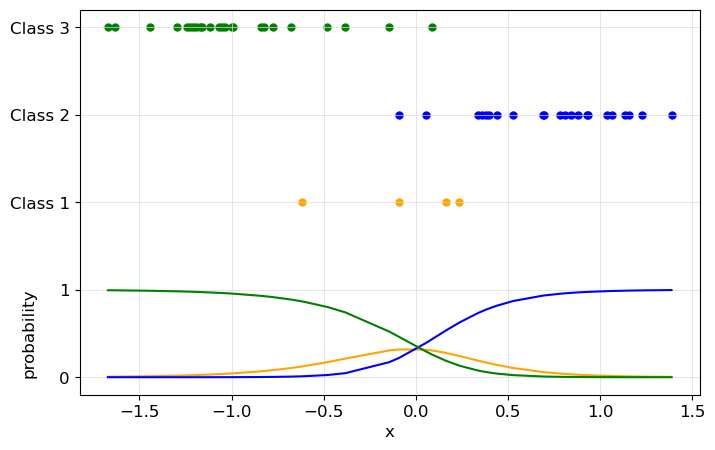

In [268]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xobs, p1, c="orange")
ax.plot(xobs, p2, c="blue")
ax.plot(xobs, p3, c="green")

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)

plt.show()

The probability curves are the true (but unknown) ones that we used to generate this synthetic dataset.

Our PyMC model is quite easy, but you have to remember to use `pytensor` rather than `numpy` to derive the probabilities. As before, note the `transpose()` to reshape the array into the shape that `pm.Multinomial` expects.

In [269]:
with pm.Model() as myModel:

    intercept2 = pm.Normal('intercept2', mu=0, sigma=10)
    slope2     = pm.Normal('slope2',     mu=0, sigma=10)
    intercept3 = pm.Normal('intercept3', mu=0, sigma=10)
    slope3     = pm.Normal('slope3',     mu=0, sigma=10)

    exp2 = pt.exp(intercept2+slope2*xobs)
    exp3 = pt.exp(intercept3+slope3*xobs)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    p = pt.transpose([p1,p2,p3])
    
    likelihood = pm.Multinomial('y', n=1, p=p, observed=yobs)
    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept2, slope2, intercept3, slope3]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


And here are the posteriors:

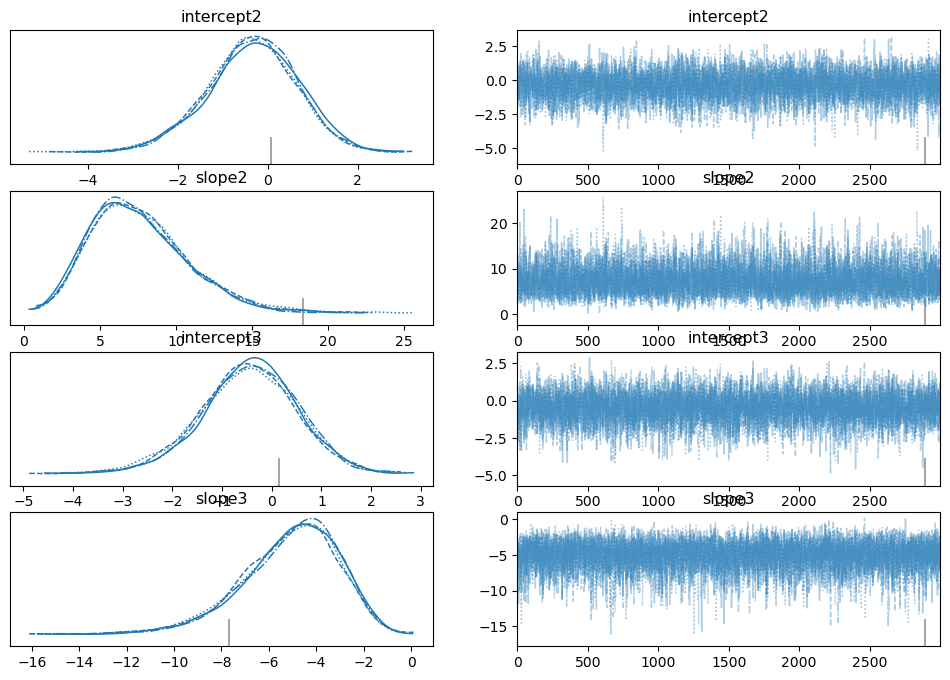

In [270]:
ax = az.plot_trace(trace, var_names=['intercept2', 'slope2', 'intercept3', 'slope3'])

Note that large uncertainties of our model parameters. This also shows in the posterior summary:

In [271]:
az.summary(trace, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept2,-0.358,1.008,-2.440,1.513,0.015,0.011,4833.784,5529.425,1.001
slope2,7.602,3.226,1.762,13.819,0.048,0.036,5087.619,4788.457,1.001
intercept3,-0.466,0.973,-2.489,1.344,0.013,0.009,6042.372,6872.329,1.001
slope3,-5.118,2.063,-9.204,-1.443,0.029,0.022,5665.022,5557.687,1.001


To plot the probability distributions on top of our dataset, we first extract the mean values for the intercepts and the slopes:

In [272]:
posteriorMean = az.summary(trace)['mean']
mean_intercept2 = posteriorMean.intercept2
mean_slope2 = posteriorMean.slope2
mean_intercept3 = posteriorMean.intercept3
mean_slope3 = posteriorMean.slope3


This allows us to compute a mean distribution for each of the $p_j(x)$:

In [273]:
xvalues = np.linspace(-1.7, 1.5, 100)
exp2 = np.exp(mean_intercept2 + mean_slope2 * xvalues)
exp3 = np.exp(mean_intercept3 + mean_slope3 * xvalues)
mean_p1 = 1.0 / (1.0 + exp2+exp3)
mean_p2 = exp2 * mean_p1
mean_p3 = exp3 * mean_p1

leading to the following figure:

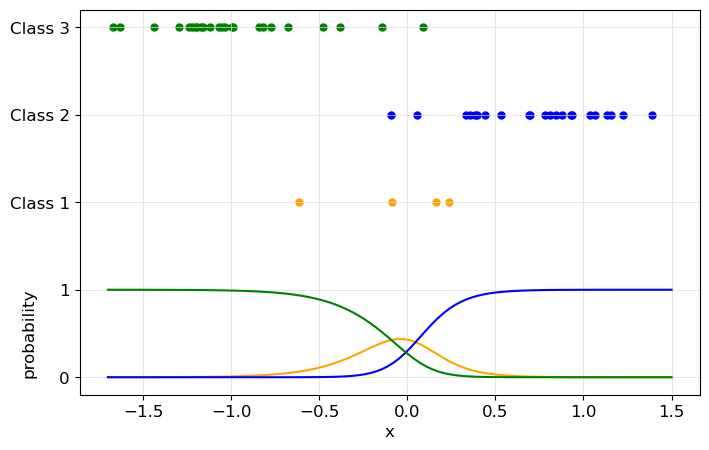

In [274]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, mean_p1, c="orange")
ax.plot(xvalues, mean_p2, c="blue")
ax.plot(xvalues, mean_p3, c="green")

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)


plt.show()

In our `PyMC` model we used the observations `yobs`. For a synthetic dataset this particular form of data is easily derived, but for a real-life dataset we usually have something similar as `observed_class`. Isn't there an easier way so that we can just use the latter? There is indeed: by using the `pm.Categorical` distribution:

In [275]:
with pm.Model() as myModel:

    intercept2 = pm.Normal('intercept2', mu=0, sigma=10)
    slope2     = pm.Normal('slope2',     mu=0, sigma=10)
    intercept3 = pm.Normal('intercept3', mu=0, sigma=10)
    slope3     = pm.Normal('slope3',     mu=0, sigma=10)

    exp2 = pt.exp(intercept2+slope2*xobs)
    exp3 = pt.exp(intercept3+slope3*xobs)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    p = pt.transpose([p1,p2,p3])
    
    likelihood = pm.Categorical('y', p, observed=observed_class)
    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept2, slope2, intercept3, slope3]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


leading to similar posteriors:

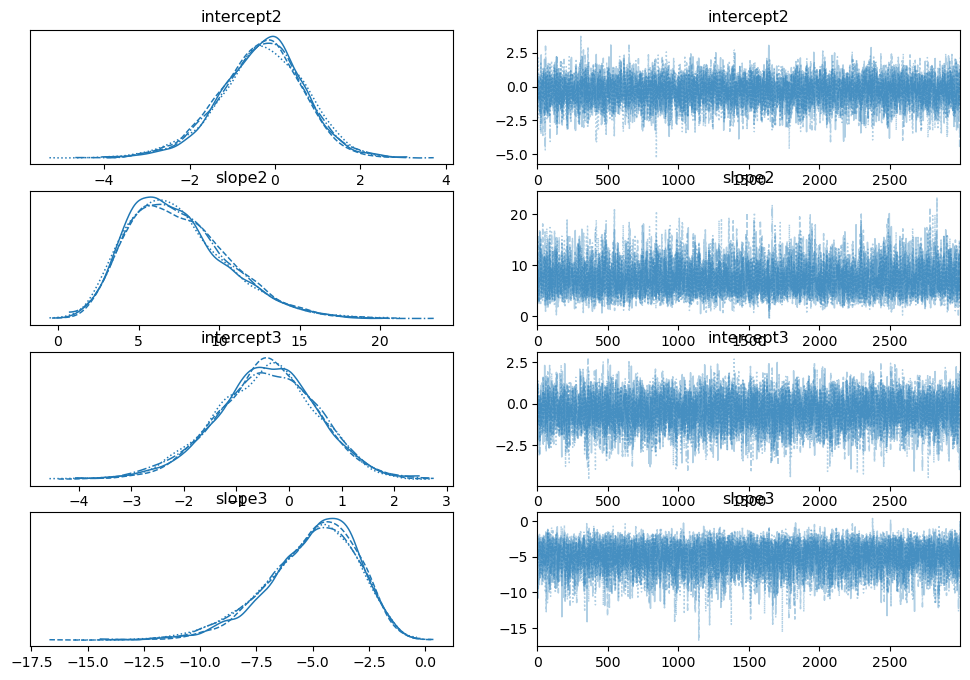

In [276]:
ax = az.plot_trace(trace, var_names=['intercept2', 'slope2', 'intercept3', 'slope3'])

Back to [contents](#Contents).

---

## Modeling a fraction with the Beta distribution with Stan

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/f_gas.csv"
data = pd.read_csv(url, comment='#')
data.head()

In [ ]:
gasFraction = data['M_HI'].values / (data['M_HI'].values + data['M_STAR'].values)
x = np.log10(data['M_STAR'].values)
myData = {'N': len(x), 'x': x, 'y': gasFraction}

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(np.log10(data['M_STAR']), gasFraction, s=10)
ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(0,1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
Nnew = 100
xnew = np.linspace(6.5, 11.5, Nnew)
myData['Nnew'] = Nnew
myData['xnew'] = xnew

The Stan script:

In [ ]:
code = \
"""
data {
    int<lower=0> N;                                   // Number of observations
    real x[N];                                        // log10(mass)
    real<lower=0, upper=1> y[N];                      // Gas fraction observations
    int<lower=0> Nnew;                                // To compute posterior prediction interval
    real xnew[Nnew]; 
}

parameters {
    real intercept;
    real slope;
    real<lower=0> kappa;                              // Beta distribution parameter
}

model {
    
    vector[N] mu;                                     // Mean of the beta distribution
    
    for (n in 1:N) {
        mu[n] = inv_logit(intercept + slope * x[n]);
    }
    
    intercept ~ normal(0, 20);
    slope ~ normal(0, 20);
    kappa ~ student_t(4,0,1);
    
    y ~ beta_proportion(mu, kappa);
}

generated quantities {
    
    real aa[Nnew];
    real bb[Nnew];
    real eta[Nnew];
    
    for (n in 1:Nnew) {
        eta[n] = inv_logit(intercept + slope * xnew[n]); 
        aa[n] = eta[n] * kappa;
        bb[n] = (1-eta[n]) * kappa;
    }
    real ynew[Nnew] = beta_rng(aa, bb);
}
"""

In [ ]:
model = stan.build(code, data=myData, random_seed=13593)

In [ ]:
trace = model.sample(num_chains=4, num_samples=4000)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'kappa'])

In [ ]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])
xvalues = np.linspace(6.5, 11.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [ ]:
median = np.quantile(trace['ynew'], 0.5, axis=1)
lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

median = np.quantile(trace['ynew'], 0.5, axis=1)
ax.plot(xnew, median, c="red", linewidth=2)

lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)                              # 95% prediction interval
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.2)

lowerQuantile = np.quantile(trace['ynew'], 0.25, axis=1)                               #  50% prediction interval    
upperQuantile = np.quantile(trace['ynew'], 0.75, axis=1)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.6)

ax.scatter(np.log10(data['M_STAR']), gasFraction, s=10)

ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(-0.1, 1.1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Poisson with PyMC

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')
data.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(data['MV_T'], data['N_GC'], s=20)
ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The PyMC model:

In [ ]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['MV_T'].values)
    yobs = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    y          = pm.Poisson('y', mu=mu, observed=yobs)

    N = len(data['N_GC'].values)
    K = 2
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / mu) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=3941592)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'dispersion'])

In [ ]:
az.summary(trace, var_names=['intercept', 'slope', 'dispersion'], hdi_prob=0.95, round_to=3)

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1.0, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Poisson with Stan

We use the same dataset as in the previous example:

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

The Stan script:

In [ ]:
code = \
"""
data {
   int<lower=0> N;                   // Number of data points
   int<lower=0> K;                   // Number of model parameters
   matrix[N,K] X;                    // Design matrix
   int y[N];                         // Globular cluster counts
}

parameters {
   vector[K] theta;                  // Model parameters
}

transformed parameters {
   real intercept;                   // Separate quantities just to make the trace plots more clear
   real slope;
  
   intercept = theta[1];
   slope = theta[2];
}

model {
   y ~ poisson_log(X * theta);       // Poisson with mu = exp(X*theta)
}
"""

In [ ]:
X = sm.add_constant(np.column_stack([data['MV_T'].values]))                         # Design matrix
myData = {'X': X, 'y': data['N_GC'].values, 'N': X.shape[0], 'K': X.shape[1]}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

In [ ]:
trace = model.sample(num_chains=4, num_samples=5000)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [ ]:
az.summary(trace, var_names=['intercept', 'slope'])

Back to [contents](#Contents).

---

## Modeling counts with Negative Binomial with PyMC

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

In [ ]:
with pm.Model() as myModel:
    
    xobs       = pm.Data("xobs", data['MV_T'].values)
    yobs       = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    alpha      = pm.Uniform('alpha', 0, 5)
    y          = pm.NegativeBinomial('y', mu=mu, alpha=alpha, observed=yobs)
    var        = pm.Deterministic('variance', mu * (1+mu/alpha))

    N = len(data['N_GC'].values)
    K = 3
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / var) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=341592)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'alpha', 'dispersion'])

The model is still slightly overdispersed, but we can't exclude that this is caused by the fact that we somewhat misspecified our model. 

In [ ]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Negative Binomial with Stan

In [ ]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

The Stan script:

In [ ]:
code = \
"""
data {
   int<lower=0> N;                   // Number of data points
   int<lower=0> K;                   // Number of model parameters
   matrix[N,K] X;                    // Design matrix
   int y[N];                         // Observed globular cluster counts
}

parameters {
   vector[K] theta;                  // Model coefficients of the straight line
   real<lower=1e-3, upper=5> alpha;  // Negative Binomial parameter
}

transformed parameters {
   real intercept;                   // Separate quantities just to make the trace plots more clear
   real slope;
  
   intercept = theta[1];
   slope = theta[2];
}

model {
   y ~ neg_binomial_2_log(X * theta, alpha);       // Negative binomial with mu = exp(X*theta)
}

generated quantities {
   real dispersion;
   vector[N] mu;
   vector[N] variance;
   vector[N] PearsonResiduals;
   
   mu = exp(X * theta);
   for (n in 1:N) {
      variance[n] = mu[n] * (1 + mu[n]/alpha);
      PearsonResiduals[n] = pow(y[n] - mu[n], 2) / variance[n];
   }
   
   dispersion = sum(PearsonResiduals) / (N - K - 1);
}
"""

A lower value of 0 for alpha would lead to infinities, hence I avoid it.

In [ ]:
X = sm.add_constant(np.column_stack([data['MV_T'].values]))                         # Design matrix
myData = {'X': X, 'y': data['N_GC'].values, 'N': X.shape[0], 'K': X.shape[1]}

In [ ]:
model = stan.build(code, data=myData, random_seed=135)

In [ ]:
trace = model.sample(num_chains=4, num_samples=5000)

In [ ]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'alpha', 'dispersion'])

Back to [contents](#Contents).

---

## A zero-truncated Poisson model with Stan

Create an artificial dataset:

In [ ]:
y = sp.stats.poisson.rvs(mu=2.5, size=200)
y = y + 1                                                     # No zeros in our dataset 

In [ ]:
myData = {'N': len(y), 'y': y}

The Stan script: 

In [ ]:
code = \
"""
data {
   int N;
   int<lower=1> y[N];                                   // Our observed counts dataset
}

parameters {
   real<lower=0> lambda;
}

model {

   lambda ~ cauchy(0,5);                                // Half-cauchy prior

   for (n in 1:N) {
      y[n] ~ poisson(lambda)  T[1,];                    // Truncator flag T[low, high]
   }
}
"""

In [ ]:
model = stan.build(code, data=myData, random_seed=1325)

In [ ]:
trace = model.sample(num_chains=4, num_samples=3000)

In [ ]:
ax = az.plot_trace(trace)

In [ ]:
az.summary(trace)

Back to [contents](#Contents).

---

## A zero-truncated Poisson model with PyMC

Create an artificial dataset:

In [283]:
y = sp.stats.poisson.rvs(mu=2.5, size=200)
y = y + 1                                                     # No zeros in our dataset (average is now around 3.5 rather than 2.5)

To model count data that have no zero counts among them, we can use a truncated Poisson model:

In [280]:
with pm.Model() as myModel:
    
    yobs = pm.ConstantData("yobs", y)                                                                          # The observations

    mu = pm.HalfNormal("mu", sigma=4)                                                                          # The prior on the average number of counts
    truncatedPoisson = pm.Truncated("truncated_poisson", pm.Poisson.dist(mu=mu), lower=1, observed=yobs)       # Truncate the counts to be >= 1.

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=341592)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu]


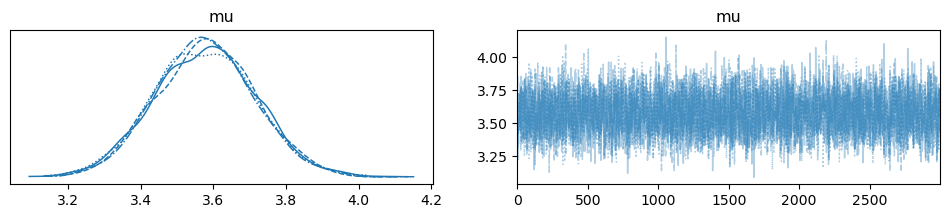

In [282]:
ax = az.plot_trace(trace)

Back to [contents](#Contents).

---